In [1]:
import torch
import PIL
from PIL import Image
import os
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from IPython import display
import cv2
import os
from torch.utils.data import DataLoader,TensorDataset
from torchvision import transforms
from resizeandpad import ResizeAndPad
from image_enhance import Enhancer
from DataUtils import Loader,ImageToTensor,PrepInput
import torch.nn as nn
import torch.nn.functional as F
from Net import Generator,Disciminator

In [2]:
def display_image(image):
    #image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [3]:
def imshow_tensor(img_tensor, title=None):
    """Display a tensor image: CHW → HWC, unnormalize if in [-1,1]"""
    img = img_tensor.clone().detach()     # avoid messing with the original tensor
    img = img * 0.5 + 0.5                  # unnormalize from [-1,1] → [0,1]
    img = img.permute(1, 2, 0)             # CHW → HWC   
    img = img.clamp(0, 1).numpy()                # convert to NumPy

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [4]:


def show_4_images(img_list, titles=None):
    """
    Display 4 images in a 2x2 grid.
    img_list: list of 4 images (PIL or numpy or torch tensors)
    titles: optional list of 4 titles
    """
    plt.figure(figsize=(10, 8))
    
    for i, img in enumerate(img_list):
        plt.subplot(2, 2, i + 1)
        
        # Convert torch.Tensor to numpy if needed
        if hasattr(img, "detach"):  # torch.Tensor
            img = img.detach().cpu()
            if img.ndim == 3:
                img = img * 0.5 + 0.5  # unnormalize if in [-1, 1]
                img = img.permute(1, 2, 0).numpy()  # CHW → HWC
        
        plt.imshow(img)
        plt.axis('off')
        if titles:
            plt.title(titles[i])
    
    plt.tight_layout()
    plt.show()
import matplotlib.pyplot as plt



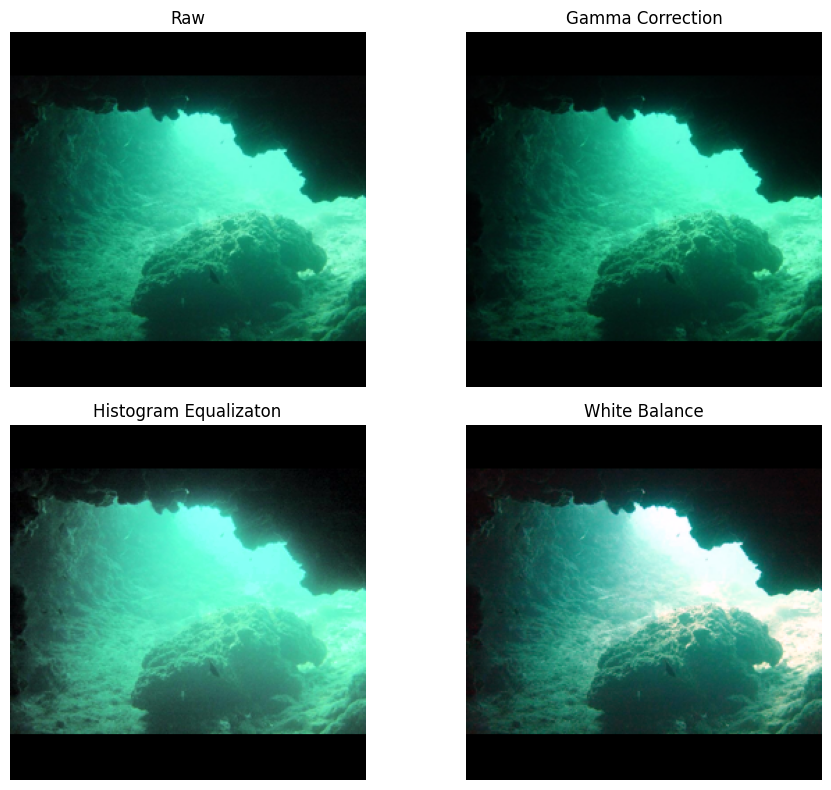

In [5]:
path = r"dataset\modified\RAW\4_img.png"
ref_path = r"dataset\modified\REF\4_img.png"
img = Image.open(path)
img_ref = Image.open(ref_path)
img = np.array(img)
enhance = Enhancer()
i1,i2,i3 = enhance.apply_all(img,.8)
img_list = [img,i1,i2,i3]

show_4_images(img_list,["Raw","Gamma Correction","Histogram Equalizaton","White Balance"])

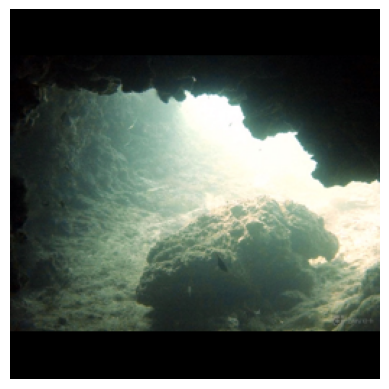

In [6]:
display_image(img_ref)

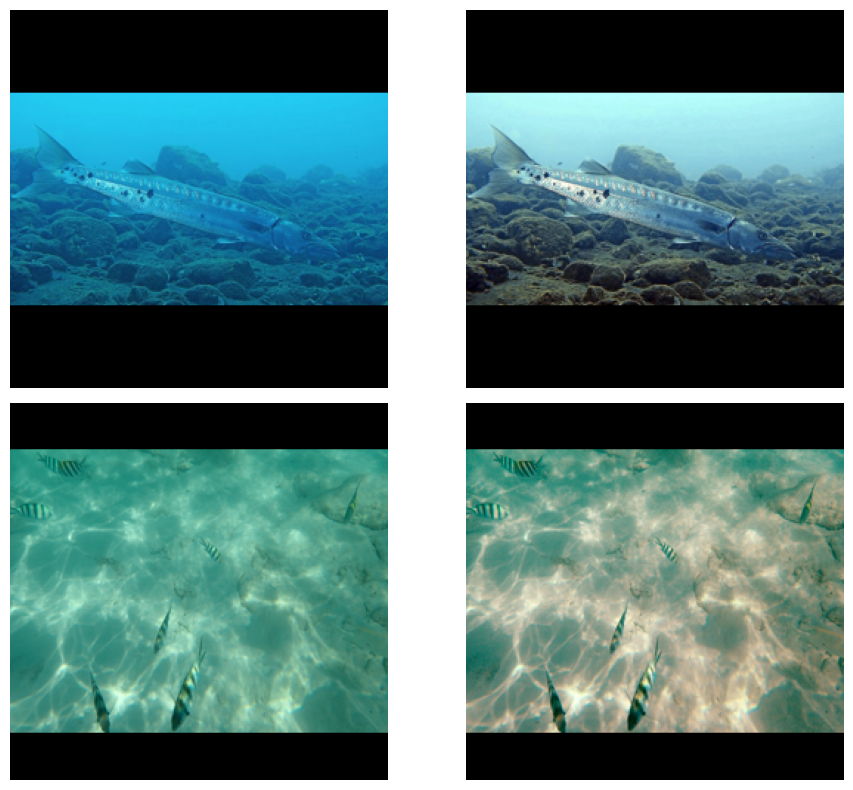

In [7]:
path = r"dataset\modified\RAW"
ref_path = r"dataset\modified\REF"
dl = Loader(batch_size=8)
dl(path,ref_path)
raw,ref = dl.get_item(0)

show_4_images([raw[0],ref[0],raw[1],ref[1]])

In [8]:
tObject = ImageToTensor("gan",(256,256))
t = tObject(img_ref)


In [9]:
from torchvision import models

'''Credit for Some functions:
    GitHub:xahidbuffon/FUnIE-GAN
'''

class VGG19_PerceptLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device)
        for param in self.vgg.parameters():
            param.requires_grad_(False)

    def get_features(self, image, layers=None):
        if layers is None:
            layers = {'30': 'conv5_2'}
        features = {}
        x = image
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
        return features

    def forward(self, pred, true, layer='relu4_5'):
        true_f = self.get_features(true, layers={'29': 'relu4_5'})
        pred_f = self.get_features(pred, layers={'29': 'relu4_5'})
        return torch.mean((true_f[layer] - pred_f[layer]) ** 2)


class GANLoss:
    def __init__(self, device="cpu", lambda_pixel=0.05, lambda_perc=1.0, lambda_adv=1.0):
        self.dev = device
        self.advLoss = nn.MSELoss()
        self.percept = VGG19_PerceptLoss(self.dev)
        self.pixel_loss = nn.MSELoss()
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.lp = lambda_pixel
        self.lperc = lambda_perc
        self.la = lambda_adv

    def normalize(self, img, mean, std):
        img = (img + 1.0) / 2.0
        mean = torch.tensor(mean).view(1, 3, 1, 1).to(self.dev)
        std = torch.tensor(std).view(1, 3, 1, 1).to(self.dev)
        return (img - mean) / std

    def compute_gen_loss(self, fake, D_fake, target):
        # fake -> generator output
        # D_fake -> result obtained from discriminator
        # target -> ground truth
        loss_adv = self.advLoss(D_fake, torch.ones_like(D_fake))
        loss_pixel = self.pixel_loss(fake, target)
        imagenet_normalized_fake = self.normalize(fake, self.mean, self.std)
        imagenet_normalized_target = self.normalize(target, self.mean, self.std)
        loss_perc = self.percept(imagenet_normalized_fake, imagenet_normalized_target, layer='relu4_5')
        total_loss = (self.la * loss_adv) + (self.lp * loss_pixel) + (self.lperc * loss_perc)

        return total_loss

    def compute_disc_loss(self, pred_real, pred_fake):
        valid = torch.full_like(pred_real, .9, device=self.dev)
        fake = torch.full_like(pred_fake, .0, device=self.dev)
        loss_real = self.advLoss(pred_real, valid)
        loss_fake = self.advLoss(pred_fake, fake)

        lossD = 0.5 * (loss_real + loss_fake) * 10
        return lossD


In [10]:
#Sanity Check for loss function

'''gLoss = GANLoss()
pred_real = disc(t1,tref)
print(pred_real.shape)
pred_fake = disc(t1,output)
print(pred_fake.shape)
dloss = gLoss.compute_disc_loss(pred_real,pred_fake)
gloss = gLoss.compute_gen_loss(t1,output_desc,tref)
print(gloss)
print(dloss)

loss_adv = gLoss.advLoss(pred_fake, torch.ones_like(pred_fake))
loss_pixel = gLoss.pixel_loss(t1, tref)
vgg_norm_fake = gLoss.normalize(t1, gLoss.mean, gLoss.std)
vgg_norm_ref = gLoss.normalize(tref, gLoss.mean, gLoss.std)
loss_perc = gLoss.percept(vgg_norm_fake, vgg_norm_ref)

print("Adversarial Loss:", loss_adv.item())
print("Pixel Loss:", loss_pixel.item())
print("Perceptual Loss:", loss_perc.item())'''


'gLoss = GANLoss()\npred_real = disc(t1,tref)\nprint(pred_real.shape)\npred_fake = disc(t1,output)\nprint(pred_fake.shape)\ndloss = gLoss.compute_disc_loss(pred_real,pred_fake)\ngloss = gLoss.compute_gen_loss(t1,output_desc,tref)\nprint(gloss)\nprint(dloss)\n\nloss_adv = gLoss.advLoss(pred_fake, torch.ones_like(pred_fake))\nloss_pixel = gLoss.pixel_loss(t1, tref)\nvgg_norm_fake = gLoss.normalize(t1, gLoss.mean, gLoss.std)\nvgg_norm_ref = gLoss.normalize(tref, gLoss.mean, gLoss.std)\nloss_perc = gLoss.percept(vgg_norm_fake, vgg_norm_ref)\n\nprint("Adversarial Loss:", loss_adv.item())\nprint("Pixel Loss:", loss_pixel.item())\nprint("Perceptual Loss:", loss_perc.item())'

In [11]:
prep = PrepInput("cuda")

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
gen = Generator().to(device)
disc = Disciminator().to(device)

In [14]:
gLoss = GANLoss(lambda_pixel=.5,device=device)


In [15]:
'''gLoss = GANLoss()
pred_real = disc(t1,tref)
print(pred_real.shape)
pred_fake = disc(t1,output)
print(pred_fake.shape)
dloss = gLoss.compute_disc_loss(pred_real,pred_fake)
gloss = gLoss.compute_gen_loss(t1,output_desc,tref)
print(gloss)
print(dloss)

loss_adv = gLoss.advLoss(pred_fake, torch.ones_like(pred_fake))
loss_pixel = gLoss.pixel_loss(b, c)
vgg_norm_fake = gLoss.normalize(b, gLoss.mean, gLoss.std)
vgg_norm_ref = gLoss.normalize(c, gLoss.mean, gLoss.std)
loss_perc = gLoss.percept(vgg_norm_fake, vgg_norm_ref)

print("Adversarial Loss:", loss_adv.item())
print("Pixel Loss:", loss_pixel.item())
print("Perceptual Loss:", loss_perc.item())'''

'gLoss = GANLoss()\npred_real = disc(t1,tref)\nprint(pred_real.shape)\npred_fake = disc(t1,output)\nprint(pred_fake.shape)\ndloss = gLoss.compute_disc_loss(pred_real,pred_fake)\ngloss = gLoss.compute_gen_loss(t1,output_desc,tref)\nprint(gloss)\nprint(dloss)\n\nloss_adv = gLoss.advLoss(pred_fake, torch.ones_like(pred_fake))\nloss_pixel = gLoss.pixel_loss(b, c)\nvgg_norm_fake = gLoss.normalize(b, gLoss.mean, gLoss.std)\nvgg_norm_ref = gLoss.normalize(c, gLoss.mean, gLoss.std)\nloss_perc = gLoss.percept(vgg_norm_fake, vgg_norm_ref)\n\nprint("Adversarial Loss:", loss_adv.item())\nprint("Pixel Loss:", loss_pixel.item())\nprint("Perceptual Loss:", loss_perc.item())'

In [16]:
#Training Loop

disc_optim = torch.optim.Adam(disc.parameters(),lr=1e-4)
gen_optim = torch.optim.Adam(gen.parameters(),lr=2e-4)



In [17]:
print(len(dl.train_set))

89


In [18]:
from tqdm import tqdm
import datetime

def log_step(msg, step=None, total=None, prefix=None):
    """
    Logs a message above the tqdm progress bar without interfering with it.

    Args:
        msg (str): Message to print
        step (int, optional): Current step number
        total (int, optional): Total number of steps
        prefix (str, optional): Prefix like '✓', '[INFO]', etc.
    """
    timestamp = datetime.datetime.now().strftime("%H:%M:%S")
    bar = ""
    if step is not None and total is not None:
        bar = f"[{step}/{total}]"
    if prefix:
        prefix = f"{prefix} "
    else:
        prefix = ""

    tqdm.write(f"{prefix}{bar} [{timestamp}] {msg}")


In [19]:
import torchvision.utils as vutils
import os
from PIL import Image
import torch
import torchvision.transforms as T

def save_sample_output(epoch, batch_idx, raw_tensor, gen_tensor, gt_tensor, save_dir="outputs"):
    os.makedirs(save_dir, exist_ok=True)
    
    # De-normalize if you normalized to [-1, 1]
    def denorm(t):
        return (t * 0.5) + 0.5

    raw_img = denorm(raw_tensor.cpu().detach().clone())
    gen_img = denorm(gen_tensor.cpu().detach().clone())
    gt_img = denorm(gt_tensor.cpu().detach().clone())
    
    # Make a grid
    img_grid = vutils.make_grid(torch.cat([raw_img, gen_img, gt_img], dim=0), nrow=3,padding=2)

    # Save as image
    vutils.save_image(img_grid, f"{save_dir}/epoch{epoch+1}_batch{batch_idx}.png")


In [20]:
#test image

val_raw,val_ref = dl.get_item(0)
val_combined, val_raw_s, val_ref_s, val_p1, val_p2, val_p3 = prep(val_raw, val_ref)

test_input = val_combined[0].unsqueeze(0)
test_raw = val_raw_s[0].unsqueeze(0)
val_ref = val_ref_s[0].unsqueeze(0)
p1 = val_p1[0].unsqueeze(0)
p2 = val_p2[0].unsqueeze(0)
p3 = val_p3[0].unsqueeze(0)
print(test_input.shape,test_raw.shape,val_ref.shape,p1.shape,p2.shape,p3.shape)

torch.Size([1, 12, 256, 256]) torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256]) torch.Size([1, 6, 256, 256]) torch.Size([1, 6, 256, 256]) torch.Size([1, 6, 256, 256])


In [21]:
def save_model(model, epoch, batch, kind="gen", base_dir="model_weights"):
    """
    Saves model weights into separate folders for generator and discriminator.

    Args:
        model (torch.nn.Module): The model to save.
        epoch (int): Current epoch number.
        batch (int): Current batch number.
        kind (str): 'gen' or 'disc' to decide folder placement.
        base_dir (str): Root directory for saving weights.
    """
    # Pick subfolder based on kind
    if kind == "gen":
        save_dir = os.path.join(base_dir, "generator")
    elif kind == "disc":
        save_dir = os.path.join(base_dir, "discriminator")
    else:
        raise ValueError("kind must be 'gen' or 'disc'")

    os.makedirs(save_dir, exist_ok=True)

    # Filename format
    filename = f"{kind}_epoch{epoch+1}_batch{batch}.pth"
    filepath = os.path.join(save_dir, filename)

    # Save weights
    torch.save(model.state_dict(), filepath)
    print(f"✓ Saved {kind} model weights at {filepath}")



In [22]:
from torch.amp import GradScaler,autocast
import sys 
import time
from IPython.display import clear_output

scaler_gen = GradScaler()
scaler_disc = GradScaler()

epochs = 15

gen_loss = []
disc_loss = []

for epoch in (range(epochs)):
    gen.train()
    disc.train()
    print(f"Epoch = {epoch + 1}/{epochs}")
    batch_loss_gen = []
    batch_loss_disc = []
    total = len(dl.train_set)
    for i in range(total):
        #print(f"Batch: {i+1}")
        start_batch = time.time()

        raw,ref = dl.get_item(i)

        combined,raw_s,ref_s,pair1,pair2,pair3 = prep(raw,ref)
        
       
        with autocast(device_type=device):
            fake = gen(combined,pair1,pair2,pair3)
            fake_det = fake.detach()

            pred_real = disc(raw_s,ref_s)
            pred_fake = disc(raw_s,fake_det)
            log_step("Discriminator  Forward step complete", step=i+1, total=total, prefix="✓")

            loss_d = gLoss.compute_disc_loss(pred_real,pred_fake)

        batch_loss_disc.append(loss_d.item())


        disc_optim.zero_grad()
        scaler_disc.scale(loss_d).backward()
        scaler_disc.step(disc_optim)
        scaler_disc.update()

        log_step("Discriminator backprop complete", step=i+1, total=total, prefix="✓")


        #train generator
        
        with autocast(device_type=device):
            fake = gen(combined,pair1,pair2,pair3)
            pred_fake = disc(raw_s,fake)
            log_step("Generator Forward step complete", step=i+1, total=total, prefix="✓")

            gloss = gLoss.compute_gen_loss(fake,pred_fake,ref_s)
        batch_loss_gen.append(gloss.item())



        gen_optim.zero_grad()
        scaler_gen.scale(gloss).backward()
        scaler_gen.step(gen_optim)
        scaler_gen.update()

        #print("Backprop in gen done")
        log_step("Generator backprop complete", step=i+1, total=total, prefix="✓")

        if(i%20 == 0):
            gen.eval()
            val_fake = gen(test_input,p1,p2,p3)
            print(val_fake.shape,test_raw.shape,val_ref.shape)
            save_sample_output(epoch,i,test_raw,val_fake,val_ref)
            save_model(gen,epoch,batch=i,kind="gen")
            save_model(disc,epoch,batch=i,kind="disc")

            log_step("Output Saved.")

        clear_output(wait=True)
        batch_time = time.time() - start_batch
        progress = (i + 1) / total * 100
        
        gen_loss_val = batch_loss_gen[-1] if batch_loss_gen else 0
        disc_loss_val = batch_loss_disc[-1] if batch_loss_disc else 0
        
        status = f"\rEpoch {epoch+1} [{i+1:3d}/{total}] ({progress:5.1f}%) | "
        status += f"Gen: {gen_loss_val:.4f} | Disc: {disc_loss_val:.4f} | "
        status += f"Time: {batch_time:.2f}s/batch"
        
        tqdm.write(status)
        #sys.stdout.flush()
        

        del fake, fake_det, pred_real, pred_fake, loss_d, gloss


    torch.cuda.empty_cache()
    gen_loss.append(np.mean(batch_loss_gen))
    disc_loss.append(np.mean(batch_loss_disc))
    

    print(f"Epoch {epoch+1} - Gen Loss: {gen_loss[-1]:.4f}, Disc Loss: {disc_loss[-1]:.4f}\n")

        

Epoch 15 [ 89/89] (100.0%) | Gen: 0.8682 | Disc: 1.6859 | Time: 0.46s/batch
Epoch 15 - Gen Loss: 0.9413, Disc Loss: 1.8946



5 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26101846..1.3427726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19438255..1.418556].


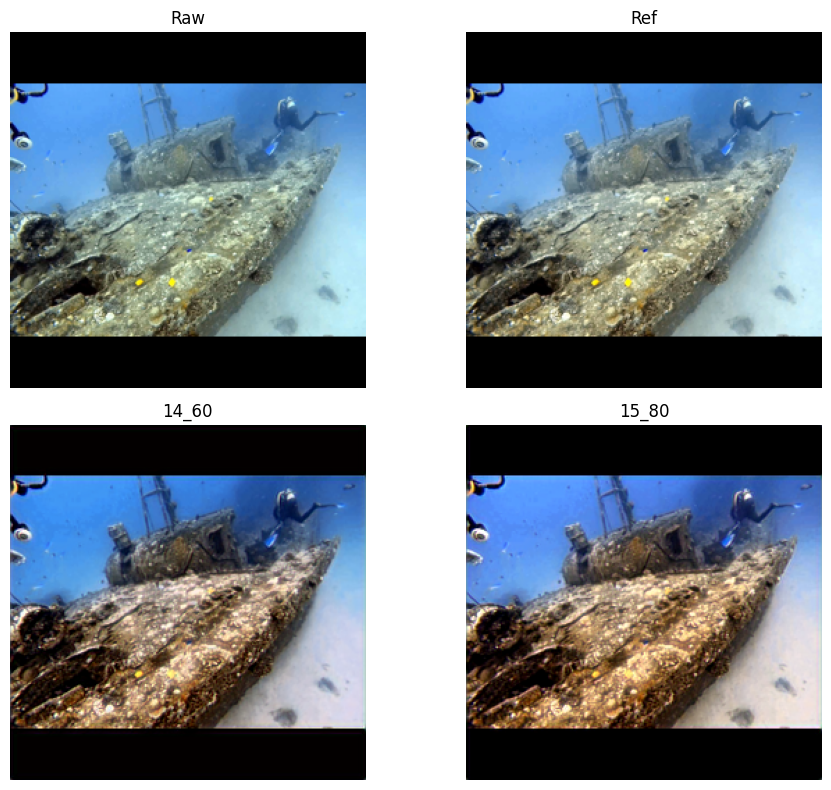

In [70]:
import random
j = random.randint(0,21)

raw,ref = dl.get_item(j,train=False)
combined,raw_s,ref_s,pair1,pair2,pair3 = prep(raw,ref)

i = random.randint(0,7)


new_gen_12 = Generator().to(device)
new_gen_other = Generator().to(device)
new_gen_12.load_state_dict(torch.load(r"Models_to_keep\Generator\gen_epoch14_batch60.pth",map_location=device))
new_gen_other.load_state_dict(torch.load(r"Models_to_keep\Generator\gen_epoch15_batch80.pth",map_location=device))
new_gen_12.eval()
new_gen_other.eval()
c = combined[i].unsqueeze(0)
p1 = pair1[i].unsqueeze(0)
p2 = pair2[i].unsqueeze(0)
p3 =  pair3[i].unsqueeze(0)
output_12 = new_gen_12(c,p1,p2,p3).squeeze(0)
output_other = new_gen_other(c,p1,p2,p3).squeeze(0)


print(j,i)

show_4_images([raw_s[i].cpu(),ref_s[i].cpu(),output_12.cpu(),output_other.cpu()],["Raw","Ref","14_60","15_80"])
